data_manager.py
yfinacne api를 이용해 증권 시장 데이터를 불러오고 저장하는 모듈

In [98]:
import pandas as pd
import numpy as np
import yfinance as yf

WIKI = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tables = pd.read_html(WIKI, storage_options={"User-Agent": "Mozilla/5.0"})
sp500 = tables[0]
sp500["ticker"] = sp500["Symbol"].astype(str).str.replace(".", "-", regex=False)
tickers = sp500["Symbol"].astype(str).str.replace(".", "-", regex=False).unique().tolist()


initial_df = yf.download(
    tickers=tickers,            
    period="3mo",
    interval="1d",
    auto_adjust=False,
    group_by="ticker",
    progress=False,
)

data = (
    initial_df
      .stack(0)                          
      .rename_axis(['date', 'ticker'])   
      .reset_index()[['ticker', 'date', 'Close', 'Volume']] 
      .sort_values(['ticker', 'date']) 
      .reset_index(drop=True)
)

sector = sp500[['ticker', 'GICS Sector']]
data = data.merge(sector, on='ticker', how='left')
data = data.sort_values(by=['ticker', 'date'])

data.to_csv('yfinance_data.csv')


/tmp/ipykernel_12168/2551881001.py:23: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(0)


preprocessing.py
1. data_manager.py를 통해 얻은 데이터로 일별 수익률을 구함
2. data_manger.py를 통해 얻은 데이터로 월별 상태를 구함(월별 평균 수익률, 분산, 표준편차)
3. 종목별 상관계수를 구함


In [99]:
import pandas as pd
import numpy as np


daily_returns = data.copy()
daily_returns['Daily_Return'] = daily_returns.groupby('ticker')['Close'].pct_change()
daily_returns.dropna()

monthly_stats = daily_returns.copy()
monthly_stats['YearMonth']  = monthly_stats['date'].dt.to_period('M')
monthly_stats = monthly_stats.groupby(['ticker', 'YearMonth']).agg(

    Monthly_Mean_Return=('Daily_Return', 'mean'),
    Monthly_Variance=('Daily_Return', 'var'),
    Monthly_Std_Dev=('Daily_Return', 'std')
).reset_index()

daily_returns.to_csv('daily_returns.csv')
monthly_stats.to_csv('monthly_stats.csv')



In [100]:
import pandas as pd
import numpy as np



wide_df = daily_returns.pivot(index='date', columns='ticker', values='Daily_Return')
wide_df['YearMonth'] = wide_df.index.to_period('M')
monthly_corrs = wide_df.groupby('YearMonth').corr(numeric_only=True)
stacked_corrs = monthly_corrs.stack()

idx = stacked_corrs.index
level_1 = idx.get_level_values(1)
level_2 = idx.get_level_values(2)

mask_self = (level_1 != level_2)
mask_unique = (level_1 < level_2)

stacked_corrs_filtered = stacked_corrs[mask_self & mask_unique]
corr_data = stacked_corrs_filtered.to_frame('Correlation')

corr_data.to_csv('corr_data.csv')

create_network.py
1. 섹터별 색상 지정
2. 상관관계 기반 네트워크 구성
3. 섹터별로 노드 색칠


In [101]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
#불러와야하는 데이터
#data
#corr_data
sector_data = data[['ticker','GICS Sector']].set_index('ticker')

In [102]:
def map_beta_to_gradient_color(beta):
    if beta < 0.50:
        return '#5DADE2' 
    elif beta < 0.60:
        return '#85C1E9'  
    elif beta < 0.70:
        return '#AED6F1'  
    elif beta < 0.85:
        return '#A3E4D7'  
    elif beta < 1.00:
        return '#76D7C4' 
    elif beta < 1.05:
        return '#F7DC6F'  
    elif beta < 1.10:
        return '#F1C40F'  
    elif beta < 1.15:
        return '#EB984E'  
    elif beta < 1.20:
        return '#C0392B'  
    else: 
        return '#7D3C98'


  
sector_avg_beta = {
    'Consumer Staples': 0.454, 'Utilities': 0.681, 'Energy': 0.684,
    'Health Care': 0.826, 'Real Estate': 0.989, 'Communication Services': 1.019,
    'Financials': 1.037, 'Materials': 1.059, 'Industrials': 1.094,
    'Consumer Discretionary': 1.171, 'Information Technology': 1.246
}
final_sector_color_map = {
    sector: map_beta_to_gradient_color(beta)
    for sector, beta in sector_avg_beta.items()
}
all_tickers = sector_data.index.unique()
final_ticker_color_map = {}
for ticker in all_tickers:
    sector = sector_data.loc[ticker, 'GICS Sector'][0]
    color = final_sector_color_map.get(sector, '#AAAAAA')
    final_ticker_color_map[ticker] = color

/tmp/ipykernel_12168/2057422565.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sector = sector_data.loc[ticker, 'GICS Sector'][0]


In [103]:
def create_correlation_network(month_df, ticker_color_map, threshold=0.85):
    filtered_df = month_df[np.abs(month_df['Correlation']) >= threshold]

    G = nx.Graph()
    edge_weights = []
    for index, row in filtered_df.iterrows():
        ticker_1 = index[1]
        ticker_2 = index[2]

        weight = abs(row['Correlation'])
        G.add_edge(ticker_1, ticker_2, weight=weight)
        edge_weights.append(weight * 5)

    node_colors_list = [ticker_color_map.get(node, '#AAAAAA') for node in G.nodes()]

    return G, edge_weights, node_colors_list

In [104]:
def get_grouped_layout_pos(graph, ticker_color_map, boost=3.0, optimal_dist=0.15, seed=42):
    G_layout = graph.copy()

    for u, v, data in G_layout.edges(data=True):
        color_u = ticker_color_map.get(u)
        color_v = ticker_color_map.get(v)
        original_w = abs(data.get('weight', 1.0))

        if color_u == color_v:
            data['weight'] = original_w * boost
        else:
            data['weight'] = original_w

    pos = nx.spring_layout(
        G_layout,
        weight='weight',
        seed=seed,
        k=optimal_dist
    )
    return pos

네트워크 생성 완료: 노드 336개, 엣지 1548개


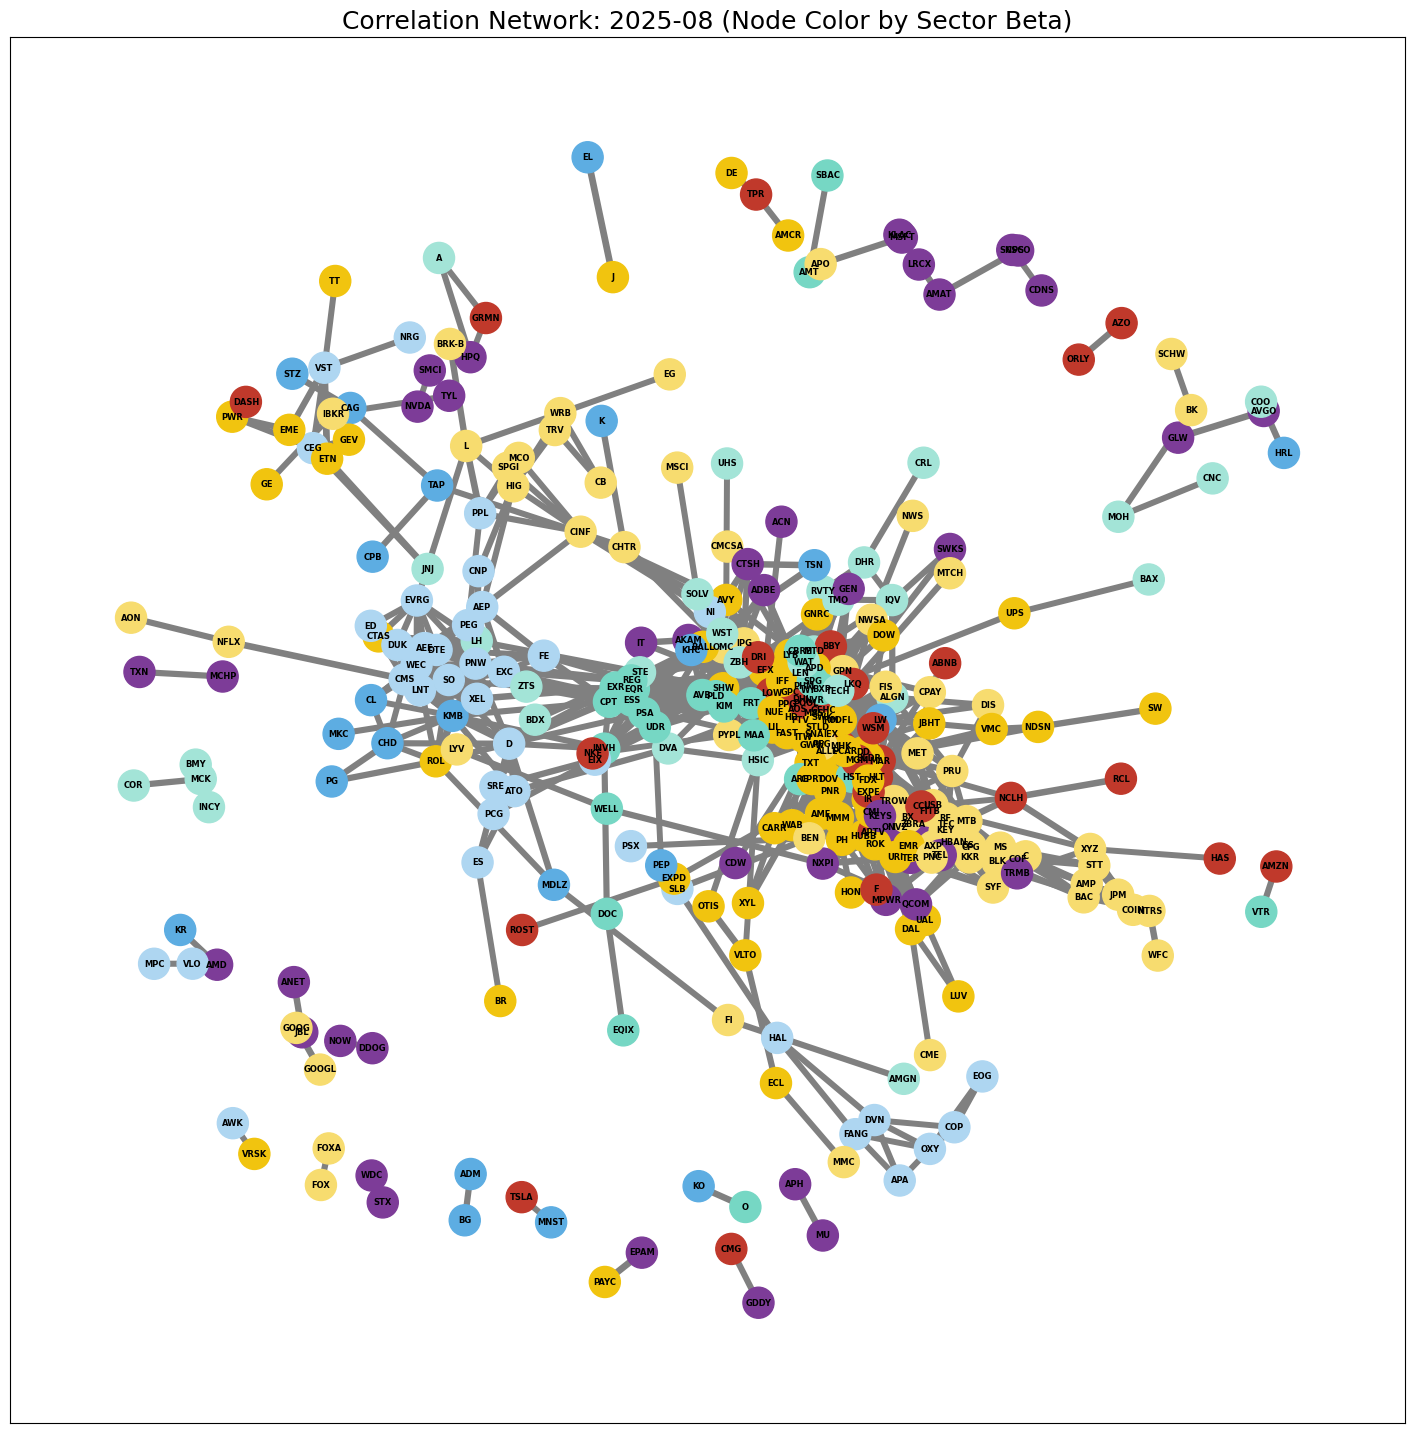

In [105]:
CORRELATION_THRESHOLD = 0.85
GROUP_BOOST = 1.5

grouped_by_month = corr_data.groupby('YearMonth')
all_months = grouped_by_month.groups.keys()

target_month = sorted(all_months)[0]

if target_month in grouped_by_month.groups:
    group_data = grouped_by_month.get_group(target_month)

    G, edge_w, node_c = create_correlation_network(
        group_data,
        final_ticker_color_map,
        threshold=CORRELATION_THRESHOLD
    )

    print(f"네트워크 생성 완료: 노드 {G.number_of_nodes()}개, 엣지 {G.number_of_edges()}개")

    pos = get_grouped_layout_pos(
        G,
        final_ticker_color_map,
        boost=GROUP_BOOST
    )

    plt.figure(figsize=(18, 18))
    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        node_size=500,
        node_color=node_c,
        edge_color='gray',
        width=edge_w,
        font_size=6,
        font_weight='bold'
    )

    plt.title(f"Correlation Network: {target_month} (Node Color by Sector Beta)", fontsize=18)
    plt.show()

else:
    print(f"데이터에 {target_month} 월이 존재하지 않습니다.")